In [1]:
import numpy as np
import scipy as scp

import h5py 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


import multiprocessing

from multiprocessing import Pool


### load  data

In [2]:
# load data

# open file
f = h5py.File("data_reextracted.hdf5", "r")

wave_normal = np.array(f['wave_control'])
wave_blocked = np.array(f['wave_blocked'])
wavelength = np.array(f['wavelength'])
opsins = np.array(f['opsins'])

for item in f.attrs:
    print(item, f.attrs[item])

f.close()

wave_blocked_raw = np.copy(wave_blocked)
wave_control_raw = np.copy(wave_normal)
opsins_raw = np.copy(opsins)

# normalizing
for i in range(4):
    wave_blocked[i] = wave_blocked[i] - np.min(wave_blocked[i])
    wave_blocked[i] = wave_blocked[i] / np.max(abs(wave_blocked[i]))
    
    wave_normal[i] = wave_normal[i] / np.max(abs(wave_normal[i]))
    
    opsins[i] =  opsins[i] - np.max(opsins[i])
    opsins[i] =  opsins[i] / np.min(opsins[i])



info: cone signals under normal and rescaled conditions. In order R,G,B,UV, aligned to wavelength axis. Same for opsins.


Text(0.5, 0, 'wavelength')

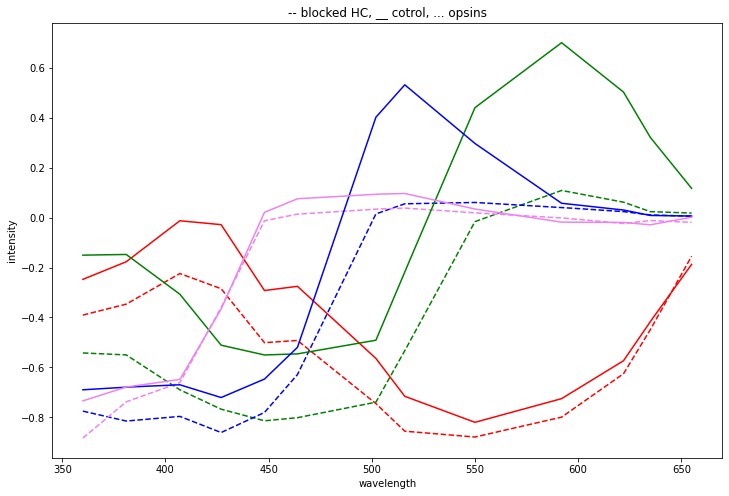

In [3]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(12,8))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked_raw[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


for i in range(4):
    plt.plot(wavelength, wave_control_raw[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

Text(0.5, 0, 'wavelength')

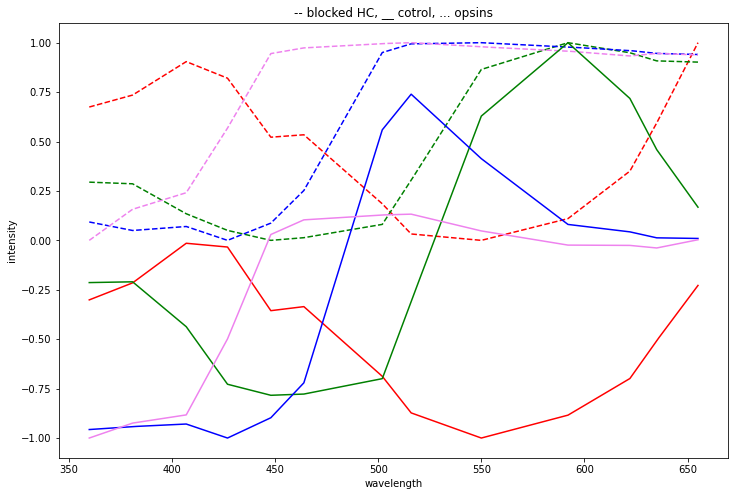

In [4]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(12,8))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


for i in range(4):
    plt.plot(wavelength, wave_normal[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

Text(0.5, 0, 'wavelength')

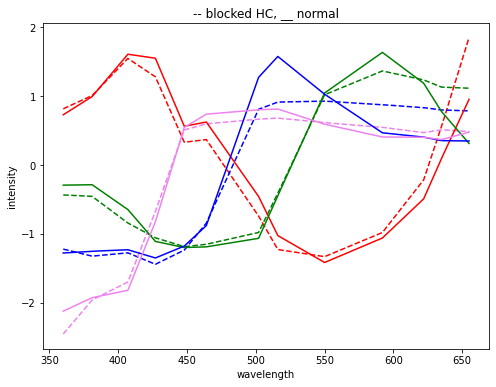

In [5]:
"""
rescaled and *(-1)
"""

def z_score(data):
    x = data-np.mean(data)
    return x/np.std(data)


colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(8,6))

plt.title('-- blocked HC, __ normal')
for i in range(4):
    plt.plot(wavelength, z_score(wave_blocked[i]), '--', color=colors[i], label='blocked')

for i in range(4):
    plt.plot(wavelength, z_score(wave_normal[i]), color=colors[i], label='normal condition')


plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

### define model

In [12]:
"""
data and functions 
"""

import sys 
sys.path.append('/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi')

from hc_model import run_model_hc, extract_params, get_param_labels
from parallel_running import run_model_x


# defining input
o = wave_blocked # seen as opsin tuning curves
k_data = wave_normal # recoreded data we want to fit




def get_loss(k_data,k_fit):
    """
    returns loss between k_data and k_fit
    SE atm
    """
    SE = 1/(np.shape(k_data)[0]*np.shape(k_data)[1]) * np.sum((k_data-k_fit)**2)
    return np.sqrt(SE)


In [6]:
"""
run model without HC
"""

# connectivity pattern
# initialize by c for found connections
const = 1
w = np.zeros((3,4))
#w[0,0]= const
#w[0,1] = const
#w[0,2] = const
#w[1,1] = const
#w[1,2] = const
#w[1,3] = const
#w[2,2] = const
#w[2,3] = const

# synaptic (output) strength per HC (HC_j -> cone) (constant over the different cone types)
a = np.zeros(3)

# dark current (can also be seen as synaptic strength cone_i -> HC )
# fixed here
dc = np.ones(4)
#dc[0] = dc0
#dc[1] = dc1
#dc[2] = 1
#dc[3] = 2
    
o = wave_blocked


k_no_HC = run_model_hc(o,w, dc,a, N=200)

loss_noHC = get_loss(k_data,k_no_HC)

In [7]:
loss_noHC

0.327282196924212

NameError: name 'H_in' is not defined

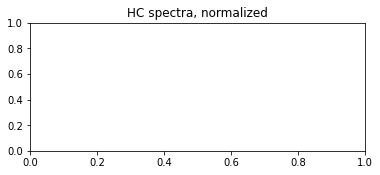

In [10]:
HC_labels=['HC0', 'HC1', 'HC2']

plt.figure(1, figsize=(6,8))
plt.subplot(3,1,1)
plt.title('HC spectra, normalized')

for HC in range(3):
    H_shift = H_in[HC] #- np.max(H_in[HC])
    plt.plot(wavelength, H_shift/np.max(np.abs(H_shift)), label =HC_labels[HC] )
    #plt.ylim(-0.2,1)
    plt.axhline(0, c='black', ls=':')

    plt.legend()

plt.subplot(3,1,2)
plt.title('HC spectra, raw')
for HC in range(3):
    plt.plot(wavelength, H_in[HC], label =HC_labels[HC] )
    #plt.ylim(-0.2,1)
    plt.axhline(0, c='black', ls=':')

    plt.legend()

    
plt.subplot(3,1,3)
for HC in range(3):
    plt.title('HC spectra * a_i (feedback strength)')
    plt.plot(wavelength, H_in[HC]*params_DELFI[-3+HC], label =HC_labels[HC] )
    #plt.ylim(-0.2,1)
    plt.axhline(0, c='black', ls=':')
    plt.legend()

sns.despine()
plt.tight_layout()

Text(0.5, 0, 'wavelength')

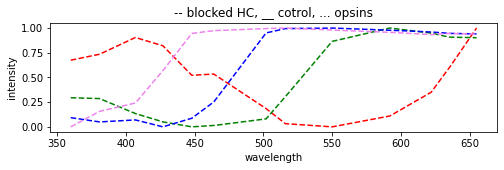

In [11]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(8,2))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


#for i in range(4):
#    plt.plot(wavelength, wave_normal[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

## load SNPE models

In [8]:
modes =   [['HC0', 'HC1', 'HC2'],
     ['HC0', 'HC1'],
     ['HC0', 'HC2'],
     ['HC1', 'HC2'],
     ['HC0'],
     ['HC1'],
     ['HC2'],
    'special']

In [13]:
"""
load Delfi best params
"""

folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/v2'



filename = 'bestparams.pkl'

with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)

    
   
"""
extract data from v2
"""

loss_delfi = np.zeros(8)
params_delfi = []
for i in range(8):
    loss_delfi[i] = dictname[i]['loss_0']
    params_delfi.append(dictname[i]['params_0'])
    
  
        
"""
runs sims
"""
k_delfi = []
loss_delfi_check = np.zeros(8)
for i in range(8):
    k_delfi.append(run_model_x(params_delfi[i], wave_blocked, mode=modes[i], N=200))
    loss_delfi_check[i] = get_loss(k_delfi[i],wave_normal)
    
    

In [15]:
loss_delfi_check

array([0.0904327 , 0.10598494, 0.10418016, 0.14998594, 0.12840582,
       0.18320363, 0.30407167, 0.08322403])

In [14]:
loss_delfi

array([0.0904327 , 0.10598494, 0.10418016, 0.14998594, 0.12840582,
       0.18320363, 0.30407167, 0.08322403])

In [16]:
modes

[['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']

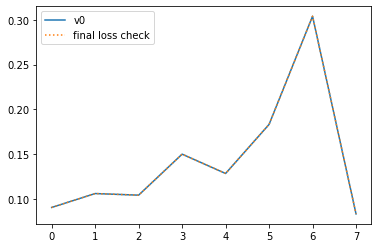

In [19]:
plt.plot(loss_delfi, label='v0')
plt.plot(loss_delfi_check, label='final loss check', ls=':')

plt.legend()

In [20]:
"""
set to best parameters
"""

# set to delfi
loss_best = np.copy(loss_delfi)
k_best = np.copy(k_delfi)
best_params = params_delfi




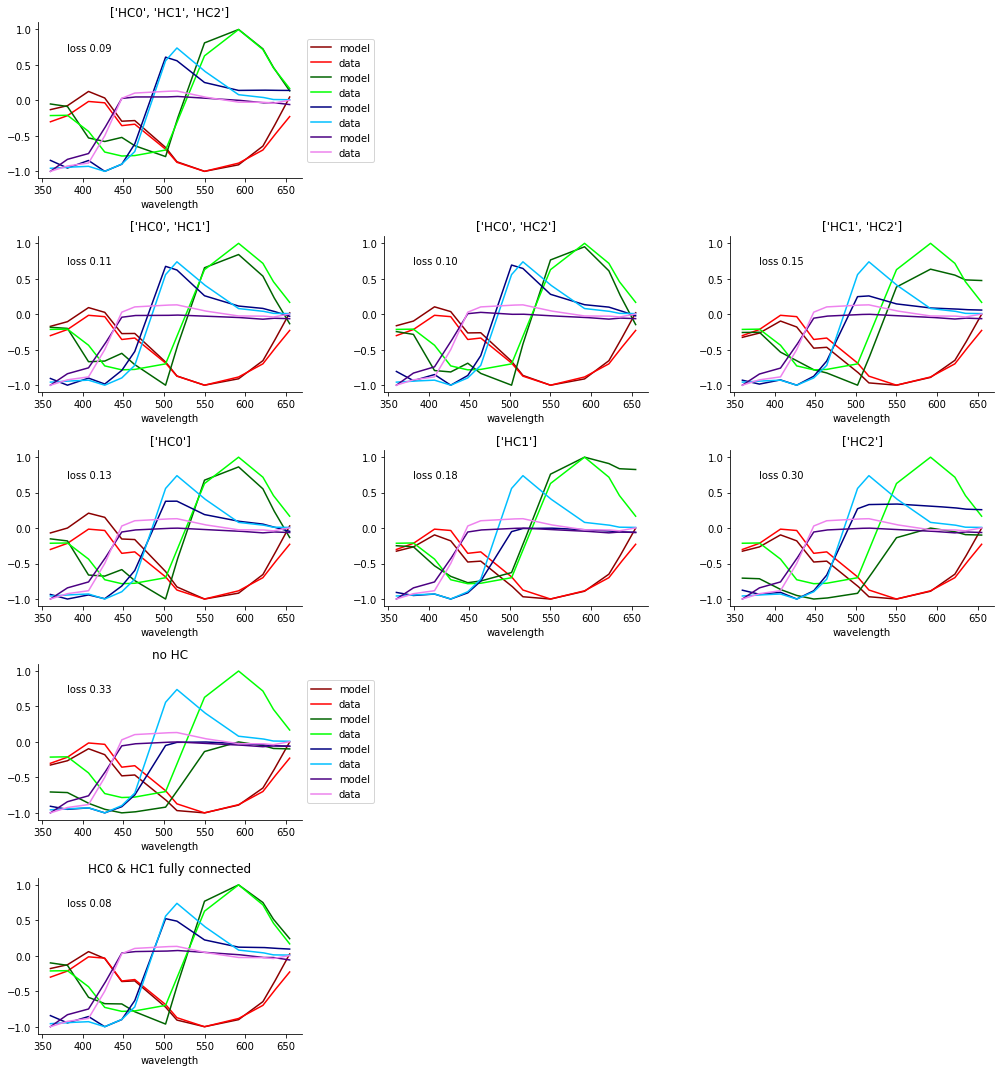

In [22]:
"""
plot best evaluations
"""
save = False

special_mode =True

colors = ['r', 'lime', 'deepskyblue','violet' ]
colors2 = ['darkred','darkgreen','navy','indigo']

plt.figure(figsize=(14,15))
c=0
for j in range(8):
    
    if j==1:
        c=2
    
    plt.subplot(5,3,j+1+c)
    if j<7:
        mode = modes[j]
        plt.title(mode)
        plt.text(380,0.7,'loss %.2f'%loss_best[j])
        for i in range(4):
            plt.plot(wavelength,k_best[j][i] ,'-', color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')
    else:
        plt.title('no HC')
        plt.text(380,0.7,'loss %.2f'%loss_noHC)
        for i in range(4):
            plt.plot(wavelength, k_no_HC[i], '-',color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')
            #plt.plot(wavelength, o[i], color=colors[i], label='data, HC-blocked', alpha=0.5)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


        
        
    
    if j==0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.xlabel('wavelength')

if special_mode:
    # plot for special mode
    plt.subplot(5,3,13)
    plt.title('HC0 & HC1 fully connected')
    plt.text(380,0.7,'loss %.2f'%loss_best[7])
    for i in range(4):
            pass
            plt.plot(wavelength,k_best[7][i] ,'-', color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')

    plt.xlabel('wavelength')

plt.tight_layout()
sns.despine()

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v2/'
    filename = 'best_models'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')

## plot losses

In [24]:
"""
load losses V2 
including of uncorrelated draws
"""

load_uncorrelated=False

# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'Delfi/fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)


# load only losses 
loss_mean2 = dictname['loss_mean'] 
loss_std2 = dictname['loss_std'] 
accepted_sims2 = dictname['accepted_sims'] 
loss_percentiles_25_75 = dictname['loss_percentiles_25_75'] 


# load losses of correct posteriors
if load_uncorrelated:

    filename = 'simulations_posteriors_uncorrelated_0.pkl'
    folderpath = 'Delfi/fit_results/v2'
    with open(folderpath+'/'+filename, "rb") as f:
        dictname = pickle.load(f)

    loss_uncorrelated_mean = dictname['loss_uncorrelated_mean']
    loss_uncorrelated_std = dictname['loss_uncorrelated_std']
    accepted_sims_uncorrelated = dictname['accepted_sims_uncorrelated']
    loss_percentiles_uncorrelated_25_75 = dictname['loss_percentiles_uncorrelated_25_75']



In [25]:
loss_percentiles_25_75

array([[0.14355029, 0.15504682, 0.16922988],
       [0.14973497, 0.16065499, 0.17539912],
       [0.14063432, 0.15354153, 0.17055402],
       [0.27931008, 0.28089459, 0.2828862 ],
       [0.14944978, 0.15757737, 0.17036237],
       [0.277604  , 0.27820706, 0.27928913],
       [0.3272822 , 0.3272822 , 0.32728238],
       [0.14449669, 0.16082823, 0.18338005]])

In [26]:
loss_all[]

array([0.0904327 , 0.10598494, 0.10418016, 0.14998594, 0.12840582,
       0.18320363, 0.30407167, 0.08322403, 0.3272822 ])

In [30]:
loss_all[np.arange(len(loss_all))!=7] 

array([0.0904327 , 0.10598494, 0.10418016, 0.14998594, 0.12840582,
       0.18320363, 0.30407167, 0.3272822 ])

In [31]:
loss_noHC

0.327282196924212

In [32]:

"""
normalize losses
"""
# loss_all = best losses

def normalize_loss(loss_base, loss, return_factor=False, fix_max=True):
    """
    loss_base: the losses to normalize on
    loss: the vector which is normalized
    fix_max: normalizes max to the fixed last entry of loss_base (noHC model)
    """
    
    shift = np.min(loss_base)
    y_base = loss_base - shift
    
    if fix_max:
        div = y_base[-1]
    else:
        div = np.max(y_base)
        
    y_base = y_base /div
    
    y = loss-shift
    y = y/div
    if return_factor:
        return y, 1/div
    else:
        return y

# normalize best losses
# exclude special mode (as it is biological not plausible)
loss_base = loss_all[np.arange(len(loss_all))!=7] 

"""
normalize mean losses

to best trace
"""

loss_norm = normalize_loss(loss_base, loss_all, return_factor=False)


loss_percentiles_norm = normalize_loss(loss_base, loss_percentiles_25_75)

#loss_percentiles_uncorrelated_norm = normalize_loss(loss_all, loss_percentiles_uncorrelated_25_75)



"""
normalize mean losses

to modes (APPEND lossnoHC before!!!)
"""
#loss_norm = normalize_loss(loss_percentiles2[:,1], loss_all, return_factor=False)

#loss_percentiles_norm = normalize_loss(loss_percentiles2[:,1], loss_percentiles2)

#loss_percentiles_uncorrelated_norm = normalize_loss(loss_percentiles2[:,1], loss_percentiles_uncorrelated)


'\nnormalize mean losses\n\nto modes (APPEND lossnoHC before!!!)\n'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


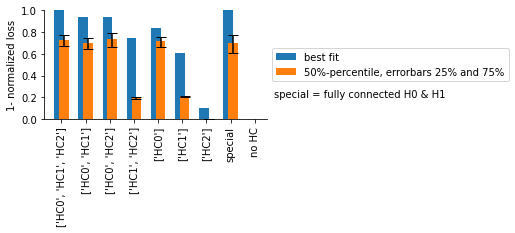

In [50]:
"""
normalized loss
"""
save = True

plot_best = True

plot_uncorrelated_loss = False

# compute errorbars
errorbars = np.abs(np.delete(loss_percentiles_norm, 1, axis=1).T 
                   - np.array([loss_percentiles_norm[:,1],
                               loss_percentiles_norm[:,1]]))[::-1]

if plot_uncorrelated_loss:
    # compute errorbars for uncorrrelated
    errorbars_uncorrelated = np.abs(np.delete(loss_percentiles_uncorrelated_norm, 1, axis=1).T 
                       - np.array([loss_percentiles_uncorrelated_norm[:,1],
                                   loss_percentiles_uncorrelated_norm[:,1]]))[::-1]


width = 0.4
if plot_uncorrelated_loss:
    shift = [-0.2,0,0.2]
else:
    shift = [-0.1,0.1]
    
modes_all = modes + ['no HC'] 
ticks = np.arange(0,9)


plt.figure(figsize=(4,2))
#plt.plot(loss_norm, 'o')


# best loss
if plot_best:
    plt.bar(ticks+shift[0],
            1-loss_norm, 
            width=width, 
           label='best fit')


# mean loss
plt.bar(ticks[:-1]+shift[1], 
        1-loss_percentiles_norm[:,1], 
        width=width,
       yerr=errorbars,
       capsize=5,
       label='50%-percentile, errorbars 25% and 75%')

# plot losses of uncorrelated samples
if plot_uncorrelated_loss:
    plt.bar(ticks[:-1]+shift[2], 
        1-loss_percentiles_uncorrelated_norm[:,1], 
        width=width,
       yerr=errorbars_uncorrelated,
       capsize=5,
       label='50%-percentile, errorbars 25% and 75%, diag-Cov')



plt.ylim(0,1)
#plt.ylabel('normalized loss')
plt.ylabel('1- normalized loss')

locs, labels = plt.xticks()            # Get locations and labels
plt.xticks(ticks, modes_all,rotation=90)  # Set locations and labels

sns.despine()
#plt.tight_layout()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.text(8.8,0.2,'special = fully connected H0 & H1')

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'loss_percentiles'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

In [72]:
1-loss_norm

array([1.        , 0.97543864, 0.99154552, 0.81205404, 0.81385912,
       0.58730532, 0.09506528, 0.        ])

In [70]:
1-loss_norm[mask]

array([1.        , 0.81385912, 0.        ])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


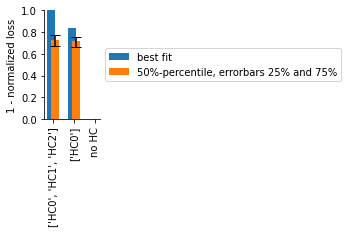

In [52]:
"""
plot only loss for the 3 models
"""
save = True

width = 0.4
if plot_uncorrelated_loss:
    shift = [-0.2,0,0.2]
else:
    shift = [-0.1,0.1]
    
modes_all = modes + ['no HC'] 

mask = [0,4,8]

ticks = np.arange(0,len(mask))
x_tick_labels = []
for i in range(len(mask)):
    x_tick_labels.append(modes_all[mask[i]])


plt.figure(figsize=(1,2))
#plt.plot(loss_norm[mask], 'o')
plt.bar(ticks+shift[0],
        1-loss_norm[mask],
       label='best fit',
       width=width)

# mean loss
plt.bar(ticks[:-1]+shift[1], 
        (1-loss_percentiles_norm[:,1])[mask[:-1]], 
        width=width,
       yerr= np.delete(errorbars,[1,2,3,5,6,7] , axis=1),
       capsize=5,
       label='50%-percentile, errorbars 25% and 75%')



# plot losses of uncorrelated samples
if plot_uncorrelated_loss:
    plt.bar(ticks[:-1]+shift[2], 
        (1-loss_percentiles_uncorrelated_norm[:,1])[mask[:-1]], 
        width=width,
       yerr=np.delete(errorbars_uncorrelated,[1,2,3,5,6] , axis=1),
       capsize=5,
       label='50%-percentile, errorbars 25% and 75%, diag-Cov')

plt.ylim(0,1)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('1 - normalized loss')
#plt.ylabel('covered exp')

ax=plt.gca()

locs, labels = plt.xticks()            # Get locations and labels
plt.xticks(ticks, x_tick_labels,rotation=90)  # Set locations and labels

sns.despine()

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'loss_percentiles_masked'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

### plot connectivity strengths

In [104]:
"""
load sampled params
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'Delfi/fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)



    
    
    

In [54]:
modes

[['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']

In [55]:
dictname[0].keys()

dict_keys(['mode', 'a', 'mus', 'covs', 'mu_proj', 'cov_proj', 'samples', 'evaluations', 'loss', 'H_in'])

In [56]:

samples = []
for i in range(8):
    samples.append(np.array(dictname[i]['samples']))

In [57]:
mean_params = []
std_params = []
percentile_params = [[] for _ in range(8)]
for i in range(8):
    mean_params.append(np.mean(np.array(dictname[i]['samples']), axis=0))
    std_params.append(np.std(np.array(dictname[i]['samples']), axis=0))
    percentile_params[i].append(np.percentile(np.array(dictname[i]['samples']),25, axis=0))
    percentile_params[i].append(np.percentile(np.array(dictname[i]['samples']),50, axis=0))
    percentile_params[i].append(np.percentile(np.array(dictname[i]['samples']),75, axis=0))

In [59]:
get_param_labels(['HC1'])

['w11', 'w12', 'w13', 'a1']

In [65]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['save', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [179]:
# compute errorbars
errorbars = np.abs(np.delete(percentile_params_clipped, 1, axis=1).T 
                   - np.array([percentile_params_clipped[:,1],
                               percentile_params_clipped[:,1]]))

In [181]:
errorbars.shape

(2, 8)

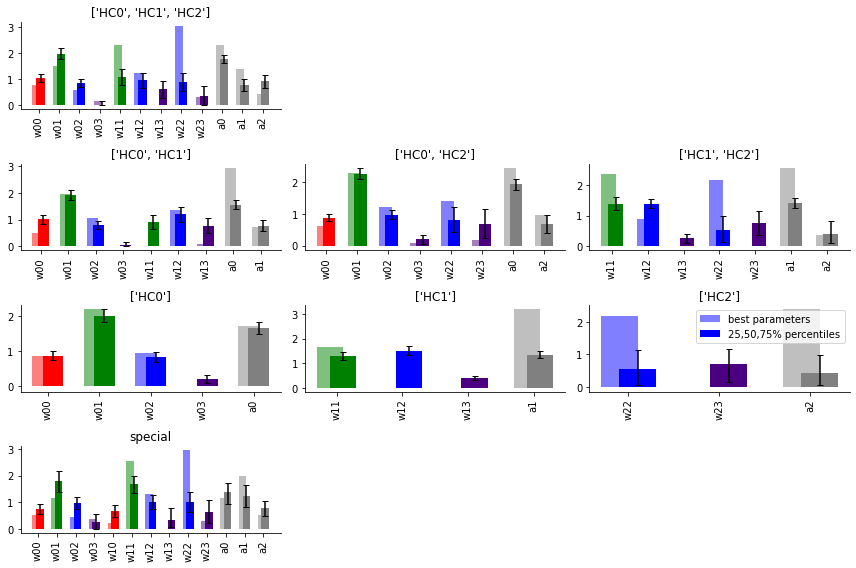

In [217]:
"""
plot fitted values 
BARPLOT PERCENTILES
"""

save = False
plot_mean = True

color = None
width = 0.4

# clip at 0 (this is done in model evaluation )
best_params_clipped = np.copy(best_params)
percentile_params_clipped = np.copy(percentile_params)

for i in range(len(best_params_clipped)):
    best_params_clipped[i][best_params_clipped[i]<0] = 0
    for j in range(3):
        percentile_params_clipped[i][j][percentile_params_clipped[i][j]<0] = 0

# compute errorbars
errorbars = np.abs(np.delete(percentile_params_clipped, 1, axis=1).T 
                   - np.array([percentile_params_clipped[:,1],
                               percentile_params_clipped[:,1]]))

# specify modes
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']
  
plt.figure(1, figsize=(12,8))
    
nround = 0

c=0
for i in range(8):
    mode = modes[i]

    if i==0:
        # all HC
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'b', 'indigo',
                'grey','grey','grey']
        #['r','g','b', 'indigo']

    elif i==1:
        # HC0 and HC1
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'grey','grey']

    elif i==2:
        # HC0 and HC2
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==3:
        # HC1 and HC2
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==4:
        # HC0
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'grey']

    elif i==5:
        # HC1 
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                 'grey']

    elif i==6:
        # HC2
        x_label =  get_param_labels(mode)
        color=['b','indigo','grey']
        
    elif i==7:
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                 'r','g','b', 'indigo',
                 'b','indigo',
                 'grey','grey', 'grey']
        
    if i==1:
        c=2
        
    ax = plt.subplot(4,3,i+1+c)
    plt.title(modes[i])
    
    # best parameters
    plt.bar(np.arange(0,len(x_label))-0.1,
            best_params_clipped[i],
           color=color,
           width=width,
           alpha=0.5,
           label='best parameters')
    
    # mean parameters
    if plot_mean:
        plt.bar(np.arange(0,len(x_label))+0.1,
            percentile_params_clipped[i][1],
           color=color,
           width=width,
               alpha=1,
               yerr=[errorbars[0][i],errorbars[1][i]],
               capsize = 3,
               label='25,50,75% percentiles')
    
    plt.xticks(np.arange(0,len(x_label)))
    ax.set_xticklabels(x_label)
    plt.xticks(rotation=90)
    plt.ylim(-0.15)
    #plt.legend()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # plot legend
    if i==6:
        plt.legend()    
plt.tight_layout()
sns.despine()



if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'weights_best_percentiles_25_75'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

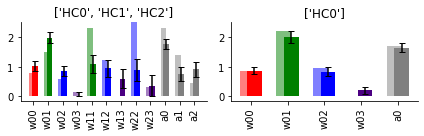

In [216]:
"""
plot fitted values 
BARPLOT PERCENTILES
SELECTED only
"""



save = False
plot_mean = True

color = None
width = 0.4

# clip at 0 (this is done in model evaluation )
best_params_clipped = np.copy(best_params)
percentile_params_clipped = np.copy(percentile_params)

for i in range(len(best_params_clipped)):
    best_params_clipped[i][best_params_clipped[i]<0] = 0
    for j in range(3):
        percentile_params_clipped[i][j][percentile_params_clipped[i][j]<0] = 0

# compute errorbars
errorbars = np.abs(np.delete(percentile_params_clipped, 1, axis=1).T 
                   - np.array([percentile_params_clipped[:,1],
                               percentile_params_clipped[:,1]]))

  
plt.figure(1, figsize=(6,2))
    
nround = 0

c=0
for i in [0,4]:
    mode = modes[i]

    if i==0:
        # all HC
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'b', 'indigo',
                'grey','grey','grey']
        #['r','g','b', 'indigo']

    elif i==1:
        # HC0 and HC1
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'grey','grey']

    elif i==2:
        # HC0 and HC2
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==3:
        # HC1 and HC2
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==4:
        # HC0
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'grey']

    elif i==5:
        # HC1 
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                 'grey']

    elif i==6:
        # HC2
        x_label =  get_param_labels(mode)
        color=['b','indigo','grey']
        
    elif i==7:
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                 'r','g','b', 'indigo',
                 'b','indigo',
                 'grey','grey', 'grey']

    if i==1:
        c=2
        
    ax = plt.subplot(1,2,c+1)
    c+=1
    plt.title(modes[i])
    
    # best parameters
    plt.bar(np.arange(0,len(x_label))-0.1,
            best_params_clipped[i],
           color=color,
           width=width,
           alpha=0.5,
           label='best parameters')
    
    # mean parameters
    if plot_mean:
        plt.bar(np.arange(0,len(x_label))+0.1,
            percentile_params_clipped[i][1],
           color=color,
           width=width,
               alpha=1,
               yerr=[errorbars[0][i],errorbars[1][i]],
               capsize = 3,
               label='25,50,75% percentiles')
    
    plt.xticks(np.arange(0,len(x_label)))
    ax.set_xticklabels(x_label)
    plt.xticks(rotation=90)
    plt.ylim(-0.15,2.5)
    #plt.legend()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.legend()    
plt.tight_layout()
sns.despine()



if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'weights_best_only'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

### as boxplot 
_see: best_model_comparison.ipynb for old code._

# compute relative input to HC

In [234]:
def normalize_h_input_weight(params, mode):
    """
    normalizes w's to sum up to 1 per HC
    and also a's to sum up to 1
    """
    params = np.copy(params)
    params[params<0]=0
    params_norm = np.zeros(params.shape)
    
    if mode==0: # all
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:7] = params[4:7]/np.sum(params[4:7])
        params_norm[7:9] = params[7:9]/np.sum(params[7:9])
        params_norm[9:] = params[9:]/np.sum(params[9:])
        
    elif mode==1: # H0,H1
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:7] = params[4:7]/np.sum(params[4:7])
        params_norm[7:] = params[7:]/np.sum(params[7:])

    elif mode==2: # H0, H2
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:6] = params[4:6]/np.sum(params[4:6])
        params_norm[6:] = params[6:]/np.sum(params[6:])
        
    elif mode==3: #H1, H2
        params_norm[:3] = params[:3]/np.sum(params[:3])
        params_norm[3:5] = params[3:5]/np.sum(params[3:5])
        params_norm[5:] = params[5:]/np.sum(params[5:])
        
    elif mode==4: #H0
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:] = params[4:]/np.sum(params[4:])

    elif mode==5: #H1
        params_norm[:3] = params[:3]/np.sum(params[:3])
        params_norm[3:] = params[3:]/np.sum(params[3:])

    elif mode==6: #H2
        params_norm[:2] = params[:2]/np.sum(params[:2])
        params_norm[2:] = params[2:]/np.sum(params[2:])
        
    elif mode==7: # special
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:8] = params[4:8]/np.sum(params[4:8])
        params_norm[8:10] = params[8:10]/np.sum(params[8:10])
        params_norm[10:] = params[10:]/np.sum(params[10:])
        
    params_norm[np.isnan(params_norm)]=0
    return params_norm

"""
normalize all samples
"""
samples_norm = [[] for _ in range(8)]
for mode in range(8):
    for sample in dictname[mode]['samples']:
        samples_norm[mode].append(normalize_h_input_weight(sample, mode))
 

"""
normalize best params
"""
best_params_norm = [[] for _ in range(8)]
for mode in range(8):
    best_params_norm[mode].append(normalize_h_input_weight(best_params[mode], mode))
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encounter

In [235]:
"""
compute percentiles of normalized params
"""
mean_params_norm = []
std_params_norm = []
percentile_params_norm = [[] for _ in range(8)]
for i in range(8):
    mean_params_norm.append(np.mean(samples_norm[i], axis=0))
    std_params_norm.append(np.std(samples_norm[i], axis=0))
    percentile_params_norm[i].append(np.percentile(samples_norm[i], 25, axis=0))
    percentile_params_norm[i].append(np.percentile(samples_norm[i], 50, axis=0))
    percentile_params_norm[i].append(np.percentile(samples_norm[i], 75, axis=0))
percentile_params_norm = np.array(percentile_params_norm) 
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

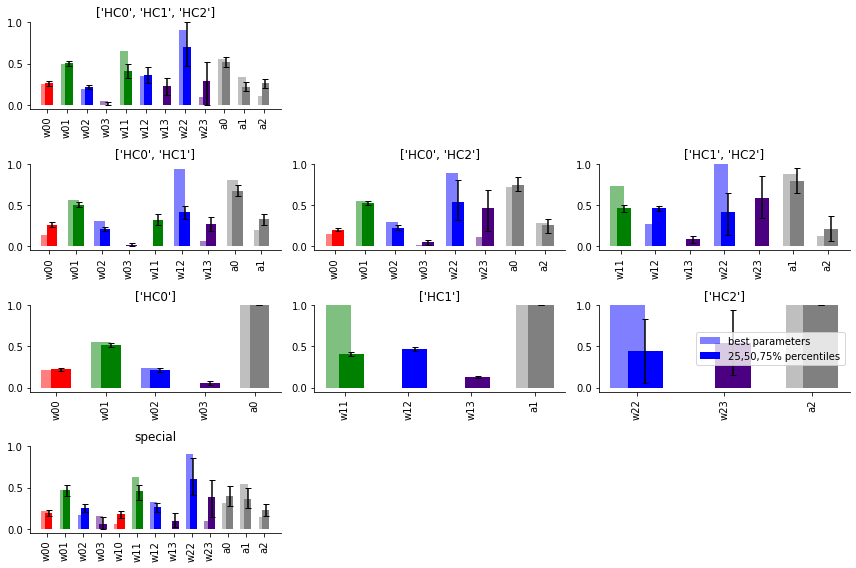

In [237]:
"""
plot NORMALIZED fitted values 
BARPLOT PERCENTILES
"""

save = True
plot_mean = True

color = None
width = 0.4



# compute errorbars
errorbars = np.abs(np.delete(percentile_params_norm, 1, axis=1).T 
                   - np.array([percentile_params_norm[:,1],
                               percentile_params_norm[:,1]]))

# specify modes
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']
  
plt.figure(1, figsize=(12,8))
    
nround = 0

c=0
for i in range(8):
    mode = modes[i]

    if i==0:
        # all HC
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'b', 'indigo',
                'grey','grey','grey']
        #['r','g','b', 'indigo']

    elif i==1:
        # HC0 and HC1
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'grey','grey']

    elif i==2:
        # HC0 and HC2
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==3:
        # HC1 and HC2
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==4:
        # HC0
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'grey']

    elif i==5:
        # HC1 
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                 'grey']

    elif i==6:
        # HC2
        x_label =  get_param_labels(mode)
        color=['b','indigo','grey']
        
    elif i==7:
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                 'r','g','b', 'indigo',
                 'b','indigo',
                 'grey','grey', 'grey']
        
    if i==1:
        c=2
        
    ax = plt.subplot(4,3,i+1+c)
    plt.title(modes[i])
    
    # best parameters
    plt.bar(np.arange(0,len(x_label))-0.1,
            best_params_norm[i][0],
           color=color,
           width=width,
           alpha=0.5,
           label='best parameters')
    
    # mean parameters
    if plot_mean:
        plt.bar(np.arange(0,len(x_label))+0.1,
            percentile_params_norm[i][1],
           color=color,
           width=width,
               alpha=1,
               yerr=[errorbars[0][i],errorbars[1][i]],
               capsize = 3,
               label='25,50,75% percentiles')
    
    plt.xticks(np.arange(0,len(x_label)))
    ax.set_xticklabels(x_label)
    plt.xticks(rotation=90)
    plt.ylim(-0.05,1)
    #plt.legend()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # plot legend
    if i==6:
        plt.legend()    
plt.tight_layout()
sns.despine()



if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'weights_best_percentiles_25_75_normalized'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

# Tuning curves

In [75]:
"""
load traces
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'Delfi/fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)



In [78]:
"""
get percentiles for all traces
"""
traces_percentiles_25_75 = np.zeros((8,3,4,296))
#traces_percentiles_5_95 = np.zeros((8,3,4,296))
#traces_percentiles_34_66 = np.zeros((8,3,4,296))


for i in range(8):
    traces_percentiles_25_75[i,0] = np.percentile(np.array(dictname[i]['evaluations']),25, axis=0)
    traces_percentiles_25_75[i,1] = np.percentile(np.array(dictname[i]['evaluations']),50, axis=0)
    traces_percentiles_25_75[i,2] = np.percentile(np.array(dictname[i]['evaluations']),75, axis=0)
    
    #traces_percentiles_5_95[i,0] = np.percentile(np.array(dictname[i]['evaluations']),5, axis=0)
    #traces_percentiles_5_95[i,1] = np.percentile(np.array(dictname[i]['evaluations']),50, axis=0)
    #traces_percentiles_5_95[i,2] = np.percentile(np.array(dictname[i]['evaluations']),95, axis=0)
    
    #traces_percentiles_34_66[i,0] = np.percentile(np.array(dictname[i]['evaluations']),34, axis=0)
    #traces_percentiles_34_66[i,1] = np.percentile(np.array(dictname[i]['evaluations']),50, axis=0)
    #traces_percentiles_34_66[i,2] = np.percentile(np.array(dictname[i]['evaluations']),66, axis=0)
    print('finished mode',i)

finished mode 0
finished mode 1
finished mode 2
finished mode 3
finished mode 4
finished mode 5
finished mode 6
finished mode 7


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

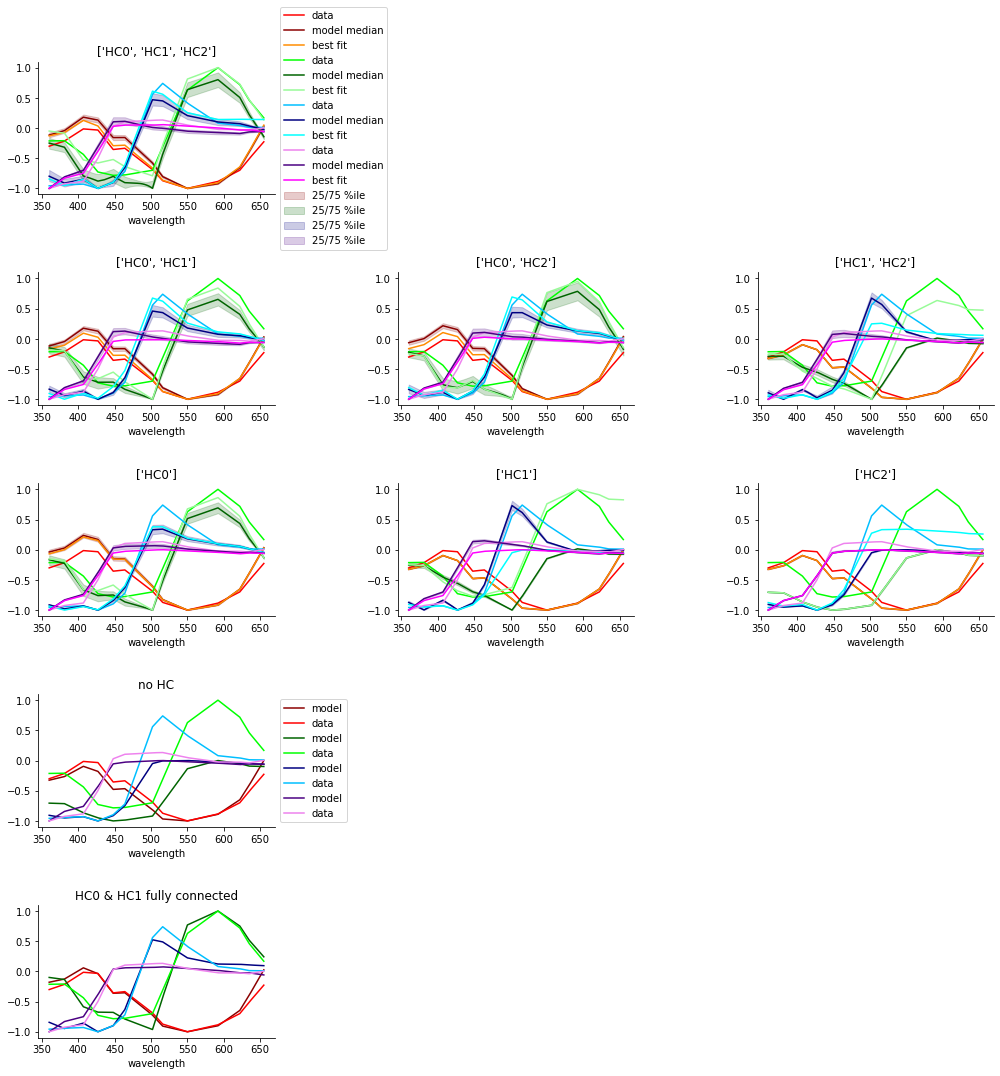

In [87]:

"""
plot 
"""
save = True

special_mode =True

plot_best = True

traces_percentiles = np.copy(traces_percentiles_25_75)

colors = ['r', 'lime', 'deepskyblue','violet' ]
colors2 = ['darkred','darkgreen','navy','indigo']
colors_best = ['darkorange', 'palegreen', 'cyan', 'magenta']

plt.figure(figsize=(14,15))
c=0
for j in range(8):
    
    if j==1:
        c=2
    
    plt.subplot(5,3,j+1+c)
    if j<7:
        mode = modes[j]
        plt.title(mode)
        #plt.text(380,0.7,'loss %.2f'%loss_best[j])
        for i in range(4):
            # data
            plt.plot(wavelength, 
                     wave_normal[i],
                     '-', 
                     color=colors[i], 
                     label='data')
            
            # fit median
            plt.plot(wavelength, 
                     traces_percentiles[j,1,i], '-', 
                     color=colors2[i], 
                     label='model median')    
            plt.fill_between(wavelength, 
                             traces_percentiles[j,0,i], 
                             traces_percentiles[j,2,i],
                             color=colors2[i], 
                             alpha=0.2, 
                             label='25/75 %ile')
            # fit best
            if plot_best:
                plt.plot(wavelength,k_best[j][i] ,
                         '-', 
                         color=colors_best[i], 
                         label='best fit')
                
                
        plt.ylim(-1.1,1.1)
        
    else:
        plt.title('no HC')
        #plt.text(380,0.7,'loss %.2f'%loss_noHC)
        for i in range(4):
            plt.plot(wavelength, k_no_HC[i], '-',color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')
            #plt.plot(wavelength, o[i], color=colors[i], label='data, HC-blocked', alpha=0.5)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


        
        
    
    if j==0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.xlabel('wavelength')

if special_mode:
    # plot for special mode
    plt.subplot(5,3,13)
    plt.title('HC0 & HC1 fully connected')
    #plt.text(380,0.7,'loss %.2f'%loss_best[7])
    for i in range(4):
            pass
            plt.plot(wavelength,k_best[7][i] ,'-', color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')

    plt.xlabel('wavelength')

plt.tight_layout()
sns.despine()

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'model_predictions'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

### compute HC spectra of best sims

In [82]:
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special'       ]#'special_H0_full']

In [83]:
"""
check output spectra
"""
H_spectra_all = []

for i, mode in enumerate(modes):
    print(i)

    w,dc,a = extract_params(best_params[i], mode=modes[i] )
    N = 200
    k_fit, H_in = run_model_hc(wave_blocked, w, dc, a, return_H_in=True)
    #k, k_store, H_in = get_output_spectra(wave_blocked,w,np.ones(4), a,N=N, return_H_in=True)
    H_spectra_all.append(H_in)

H_spectra_all = np.array(H_spectra_all)

0
1
2
3
4
5
6
7


In [84]:
H_spectra_all.shape

(8, 3, 296)

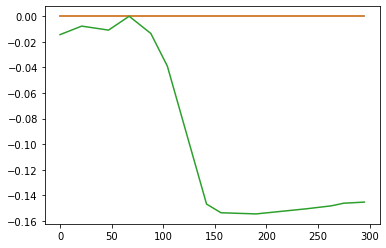

In [85]:
for i in range(3):
    plt.plot(H_spectra_all[6][i])

In [88]:
"""
load traces H_in
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'Delfi/fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)



In [89]:
"""
get percentiles for all traces
"""
H_in_percentiles_25_75 = np.zeros((8,3,3,296))
H_in_percentiles_5_95 = np.zeros((8,3,3,296))

for i in range(8):
    H_in_percentiles_25_75[i,0] = np.percentile(np.array(dictname[i]['H_in']),25, axis=0)
    H_in_percentiles_25_75[i,1] = np.percentile(np.array(dictname[i]['H_in']),50, axis=0)
    H_in_percentiles_25_75[i,2] = np.percentile(np.array(dictname[i]['H_in']),75, axis=0)
    
    #H_in_percentiles_5_95[i,0] = np.percentile(np.array(dictname[i]['H_in']),5, axis=0)
    #H_in_percentiles_5_95[i,1] = np.percentile(np.array(dictname[i]['H_in']),50, axis=0)
    #H_in_percentiles_5_95[i,2] = np.percentile(np.array(dictname[i]['H_in']),95, axis=0)
    print('finished mode',i)

finished mode 0
finished mode 1
finished mode 2
finished mode 3
finished mode 4
finished mode 5
finished mode 6
finished mode 7


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

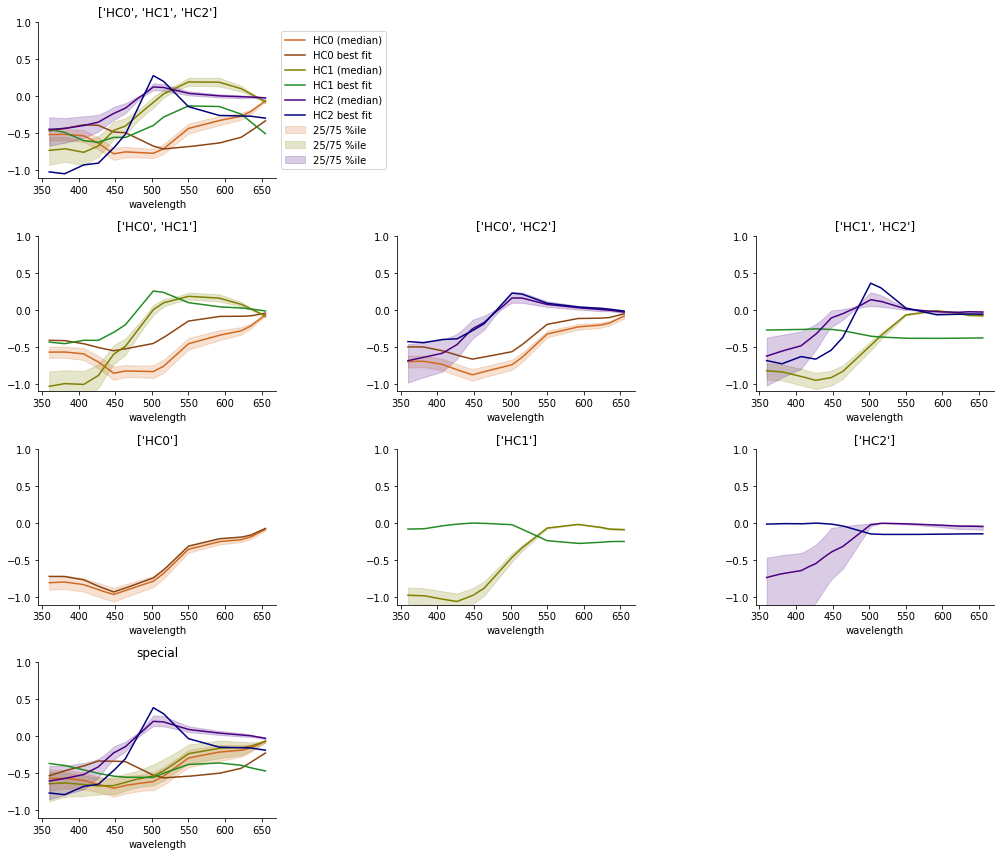

In [102]:
"""
plot HC 
"""
save=True

plot_best = True

special_mode=True


H_in_percentiles = np.copy(H_in_percentiles_25_75)

nrHC = [[0,1,2],[0,1],[0,2],[1,2],[0],[1],[2],[0,1,2]]

colors = ['chocolate', 'olive', 'indigo' ]
colors_best = ['saddlebrown', 'forestgreen', 'navy' ]


plt.figure(figsize=(14,12))
c=0
for j in range(8):
    
    if j==1:
        c=2
    
    plt.subplot(4,3,j+1+c)
    mode = modes[j]
    plt.title(mode)

    # plot only necessary HC
    for i in nrHC[j]:
        #plt.plot(wavelength,H_spectra_all[j][i],#/np.max(abs(H_spectra_all[j][i])),
        #         '-', 
        #         color=colors[i], 
        #         label='HC%.i'%i)          

        plt.plot(wavelength, 
                 H_in_percentiles[j,1,i], '-', 
                 color=colors[i], 
                 label='HC%.i (median)'%i)    
        plt.fill_between(wavelength, 
                         H_in_percentiles[j,0,i], 
                         H_in_percentiles[j,2,i],
                         color=colors[i], 
                         alpha=0.2, 
                         label='25/75 %ile')

        if plot_best:
            plt.plot(wavelength, 
                     H_spectra_all[j][i],
                     ls='-',
                     color=colors_best[i],
                    label='HC%.i best fit'%i)
                
    if j==0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.xlabel('wavelength')
    plt.ylim(-1.1,1)
    

plt.tight_layout()
sns.despine()

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'HC_in'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

## saving results

In [97]:
k_best.shape

(8, 4, 296)

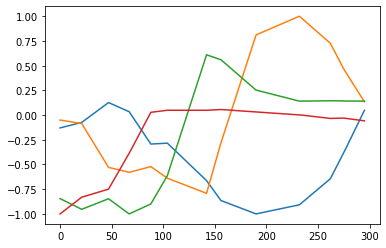

In [98]:
plt.plot(k_best[0].T)

In [101]:
"""
save relevant data
"""


# save as h5py

with h5py.File('Delfi/fit_results/v2/model_output.h5', 'w') as hf:
    hf.create_dataset("percentile_traces",  data=traces_percentiles_25_75)
    hf.create_dataset("best_traces",  data=k_best)
    hf.create_dataset("H_in_percentiles",  data=H_in_percentiles_25_75)
    hf.create_dataset("H_in_best",  data= H_spectra_all)



In [ ]:
"""
Meta data:
# model_modes, percentile (25,50,75), cone_type (r,g,b,uv) / HC_type, wavelength (360,...,655)
# modes: full, HC0&HC1, HC0&HC2, HC1&HC2, HC0, HC1, HC2
percentile_traces
H_in_percentiles


# model_modes, cone_type (r,g,b,uv) / HC_type, wavelength (360,...,655)
# modes: full, HC0&HC1, HC0&HC2, HC1&HC2, HC0, HC1, HC2
best_traces
H_in_best
"""
# load data:

with h5py.File('model_output.h5', 'r') as hf:
    percentile_traces = hf['percentile_traces'][:]
    best_traces = hf['best_traces'][:]
    H_in_percentiles = hf['H_in_percentiles'][:]
    H_in_best = hf['H_in_best'][:]
    
# all traces best
for i in range(4):
    plt.plot(best_traces[0][i])

# one trace: 25,50,75 percentiles
for i in range(3):
    plt.plot(percentile_traces[0,i,0])